In [97]:
import h5py
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sbn
import datetime as dt
import matplotlib.pyplot as plt
from tqdm.notebook import  tqdm, trange

In [93]:
pts = gpd.read_file('../../CIAT/data/BEM_2019_Chiapas_Final_Clean.gpkg')
pts['SIM'] = ['CH{0:05d}'.format(i + 1) for i in range(len(pts))]
pts = pts.set_index('SIM')
pts['ref_date'] = pd.to_datetime(pts.fecha_de_siembra)

In [70]:
dm_file = '../data/PSCE_dm.h5'
with pd.HDFStore(dm_file) as store:
    dm_SIM = store.keys()

np_file = '../data/PSCE.h5'
with pd.HDFStore(np_file) as store:
    np_SIM = store.keys()
    
SIM = np.intersect1d(dm_SIM, np_SIM)

In [136]:
w_np = np.zeros((len(SIM), 300, 6))
w_dm = np.zeros((len(SIM), 300, 6))
for i, key in enumerate(tqdm(SIM)):
    crop_start_date = pts.ref_date.dt.date.loc[key[1:]]
    sim_start_date = crop_start_date - dt.timedelta(days = 90)
    crop_end_date = crop_start_date + dt.timedelta(days = 210)

    wfile = f'/home/rodrigo7/Apsim_test/MASAGRO/PCSE{key}_npf.csv'
    w = pd.read_csv(wfile, skiprows=13)
    w.DAY = pd.to_datetime(w.DAY, format= '%Y%m%d').dt.date
    ini_idx = np.where(w.DAY == sim_start_date)[0][0]
    end_idx = np.where(w.DAY == crop_end_date)[0][0]
    s_idx = slice(ini_idx, end_idx)
    w_np[i] = w[s_idx].values[:,1:-1]

    wfile = f'/home/rodrigo7/Apsim_test/MASAGRO/PCSE{key}_dmf.csv'
    w = pd.read_csv(wfile, skiprows=13)
    w.DAY = pd.to_datetime(w.DAY, format= '%Y%m%d').dt.date
    ini_idx = np.where(w.DAY == sim_start_date)[0][0]
    end_idx = np.where(w.DAY == crop_end_date)[0][0]
    s_idx = slice(ini_idx, end_idx)
    w_dm[i] = w[s_idx].values[:,1:-1]

np.save('../data/w_dm.npy', w_dm)
np.save('../data/w_np.npy', w_np)

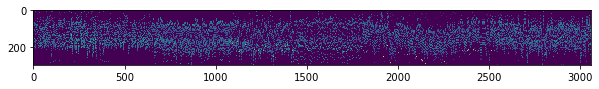

In [140]:
plt.figure(figsize=(10,10))
plt.imshow(np.sqrt(w_dm[:,:,-1].T))


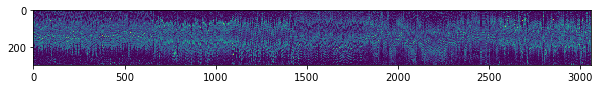

In [139]:
plt.figure(figsize=(10,10))
plt.imshow(np.sqrt(w_np[:,:,-1].T))


In [72]:
dm_file = '../data/PSCE_dm.h5'
yield_dm = np.zeros((len(SIM), 300))
with pd.HDFStore(dm_file) as store:
    for i, key in enumerate(tqdm(SIM)):
        ldf = store.select(key)[:299]
        yield_dm[i,:len(ldf)] = np.nan_to_num(ldf.TWSO)
        yield_dm[i,len(ldf):] = ldf.TWSO[-1]
        

In [73]:
np_file = '../data/PSCE.h5'
yield_np = np.zeros((len(SIM), 300))
with pd.HDFStore(np_file) as store:
    for i, key in enumerate(tqdm(SIM)):
        ldf = store.select(key)[:299]
        yield_np[i,:len(ldf)] = np.nan_to_num(ldf.TWSO)
        yield_np[i,len(ldf):] = ldf.TWSO[-1]
        

In [143]:
np.save('../data/y_dm.npy', yield_dm)
np.save('../data/y_np.npy', yield_np)

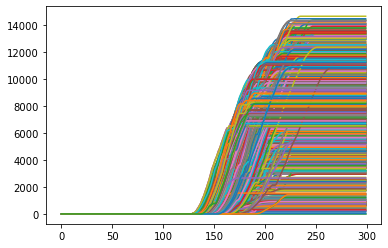

In [74]:
plt.plot(yield_dm.T)
plt.show()

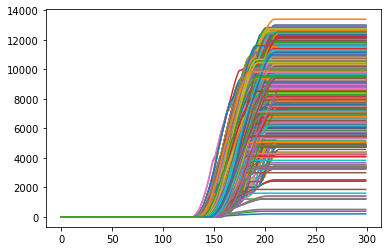

In [75]:
plt.plot(yield_np.T)
plt.show()

(array([   9.,    5.,   22.,   48.,   92.,  182.,  618., 1502.,  482.,
         103.]),
 array([  205.65443869,  1525.03069314,  2844.40694759,  4163.78320204,
         5483.15945649,  6802.53571093,  8121.91196538,  9441.28821983,
        10760.66447428, 12080.04072873, 13399.41698318]),
 <a list of 10 Patch objects>)

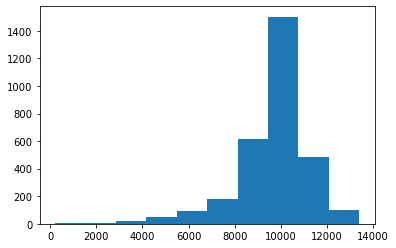

In [76]:
plt.hist(yield_np[:,-1])

(array([  56.,   39.,  125.,  177.,  521., 1060.,  588.,  339.,  118.,
          40.]),
 array([    0.        ,  1465.26507855,  2930.5301571 ,  4395.79523564,
         5861.06031419,  7326.32539274,  8791.59047129, 10256.85554984,
        11722.12062839, 13187.38570693, 14652.65078548]),
 <a list of 10 Patch objects>)

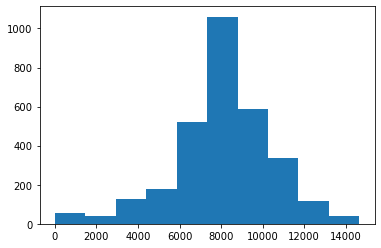

In [77]:
plt.hist(yield_dm[:,-1])

In [78]:
np.corrcoef([yield_dm[:,-1], yield_np[:,-1]])

array([[1.        , 0.41612975],
       [0.41612975, 1.        ]])